# **0. Setup and Configuration**

In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Model Evaluation
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, f1_score, precision_score, recall_score,
    classification_report, precision_recall_curve, auc
)

# Validation & Hyperparameter Tuning
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, learning_curve, cross_val_score
from collections import Counter

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
from catboost import Pool

# Model Saving & Loading
import joblib

# Warnings
import warnings
warnings.filterwarnings('ignore')

c:\Users\afsil\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# **1. Data Loading and Validation**

In [2]:
# Load datasets
df_train = pd.read_csv("train_preprocessed.csv")
df_val = pd.read_csv("val_preprocessed.csv")
df_test = pd.read_csv("test_preprocessed.csv")

df_train_cb = pd.read_csv("train_catboost.csv")
df_val_cb = pd.read_csv("val_catboost.csv")
df_test_cb = pd.read_csv("test_catboost.csv")

print("All datasets loaded successfully!")
print(f"   Training samples: {len(df_train):,}")
print(f"   Validation samples: {len(df_val):,}")
print(f"   Test samples: {len(df_test):,}")

All datasets loaded successfully!
   Training samples: 452,296
   Validation samples: 61,503
   Test samples: 48,744


In [3]:
# Prepare features and targets
X_train = df_train.drop(columns="target")
y_train = df_train["target"]
X_train_cb = df_train_cb.drop(columns="target")
y_train_cb = df_train_cb["target"]

X_test = df_test
X_test_cb = df_test_cb

X_val = df_val.drop(columns="target")
y_val = df_val["target"]
X_val_cb = df_val_cb.drop(columns="target")
y_val_cb = df_val_cb["target"]

In [4]:
# Loading feature selections
feat_map = pd.read_csv("selected_features_all_models.csv")
features_dict = {
    row["Model"]: row["Selected_Features"].split(",")
    for _, row in feat_map.iterrows()
}
print("Feature mappings loaded successfully!")

# Print feature counts for each model
for model, features in features_dict.items():
    print(f"   {model}: {len(features)} features")

# Extract features for each model
logreg_features = features_dict["LogisticRegression"]
rf_features = features_dict["RandomForest"]
xgb_features = features_dict["XGBoost"]
nb_features = features_dict["NaiveBayes"]
lgbm_features = features_dict["LightGBM"]
cb_features = features_dict["CatBoost"]

Feature mappings loaded successfully!
   LogisticRegression: 108 features
   RandomForest: 50 features
   XGBoost: 56 features
   NaiveBayes: 15 features
   LightGBM: 56 features
   CatBoost: 43 features


In [5]:
# Validating feature availability
for model_name, features in features_dict.items():
    if model_name == "CatBoost":
        missing_features = [f for f in features if f not in X_train_cb.columns]
    else:
        missing_features = [f for f in features if f not in X_train.columns]

    if missing_features:
        print(f"Warning: {model_name} missing features: {missing_features}")
    else:
        print(f"{model_name}: All features available")

# Prepare model-specific datasets
X_train_logreg = X_train[logreg_features]
X_train_rf = X_train[rf_features]
X_train_xgb = X_train[xgb_features]
X_train_nb = X_train[nb_features]
X_train_lgbm = X_train[lgbm_features]
X_train_cb = X_train_cb[cb_features]

X_test_logreg = X_test[logreg_features]
X_test_rf = X_test[rf_features]
X_test_xgb = X_test[xgb_features]
X_test_nb = X_test[nb_features]
X_test_lgbm = X_test[lgbm_features]
X_test_cb = X_test_cb[cb_features]

X_val_logreg = X_val[logreg_features]
X_val_rf = X_val[rf_features]
X_val_xgb = X_val[xgb_features]
X_val_nb = X_val[nb_features]
X_val_lgbm = X_val[lgbm_features]
X_val_cb = X_val_cb[cb_features]

# Define categorical columns
cat_cols = ["NAME_CONTRACT_TYPE", "CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "NAME_TYPE_SUITE", "NAME_INCOME_TYPE", "NAME_EDUCATION_TYPE", "NAME_FAMILY_STATUS",
           "NAME_HOUSING_TYPE", "OCCUPATION_TYPE", "WEEKDAY_APPR_PROCESS_START", "ORGANIZATION_TYPE", "HAS_BUILDING_INFO", "EXT_SOURCE_1_IS_MISSING",
           "EXT_SOURCE_2_IS_MISSING", "EXT_SOURCE_3_IS_MISSING"]
cat_cols_cb = [col for col in X_train_cb.columns if col in cat_cols]

print(f"   Categorical columns for CatBoost: {len(cat_cols_cb)}")

LogisticRegression: All features available
RandomForest: All features available
XGBoost: All features available
NaiveBayes: All features available
LightGBM: All features available
CatBoost: All features available
   Categorical columns for CatBoost: 12


# **2. Baseline Model Training**

In [ ]:
results = {}

# Enhanced evaluation function
def evaluate_model_enhanced(model, X_tr, X_te, y_tr, y_te, name, save_model=True):
    """Enhanced model evaluation with better error handling and visualization"""
    print(f"\n Training {name}...")

    # Train model
    model.fit(X_tr, y_tr)

    # Predictions
    y_pred_prob = model.predict_proba(X_te)[:, 1]
    auc_score = roc_auc_score(y_te, y_pred_prob)

    # Calculate additional metrics
    y_pred_binary = (y_pred_prob >= 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_te, y_pred_binary).ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # Store results
    results[name] = {
        'model': model,
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': y_pred_prob
    }

    # Create improved ROC plot
    fpr, tpr, _ = roc_curve(y_te, y_pred_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC={auc_score:.4f})")
    plt.plot([0,1],[0,1],'k--', alpha=0.5)
    plt.fill_between(fpr, tpr, alpha=0.1)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.title(f"ROC Curve - {name}", fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print detailed results
    print(f"{name} Results:")
    print(f"   AUC: {auc_score:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall: {recall:.4f}")
    print(f"   F1-Score: {f1:.4f}")

    # Save model if requested
    if save_model:
        model_filename = f"model_{name.lower().replace(' ', '_')}.joblib"
        joblib.dump(model, model_filename)
        print(f"   Model saved as: {model_filename}")

    return auc_score


 Training Logistic Regression...


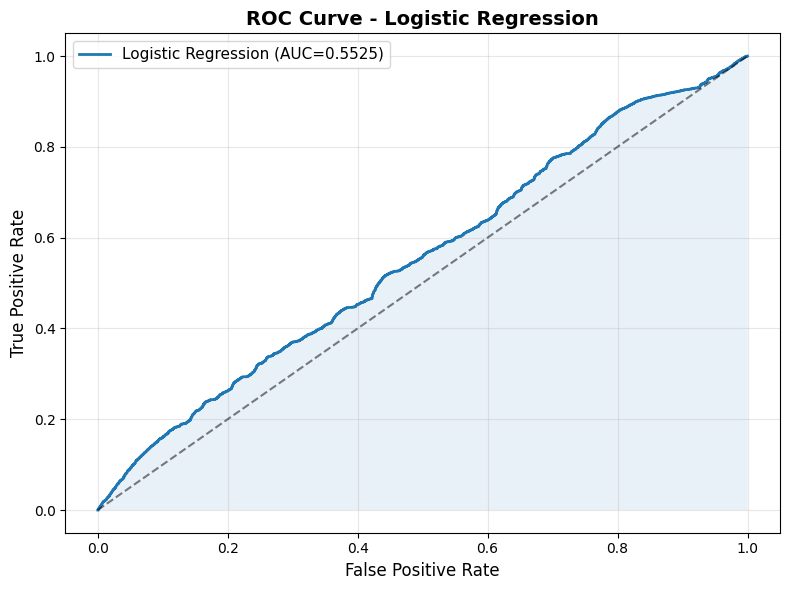

Logistic Regression Results:
   AUC: 0.5525
   Precision: 0.0986
   Recall: 0.3539
   F1-Score: 0.1543
   Model saved as: model_logistic_regression.joblib


In [ ]:
# Logistic Regression
auc_logreg = evaluate_model_enhanced(
    LogisticRegression(solver="saga", penalty="l2", C=1.0, max_iter=100, random_state=42),
    X_train_logreg, X_val_logreg, y_train, y_val, "Logistic Regression"
)


 Training Random Forest...


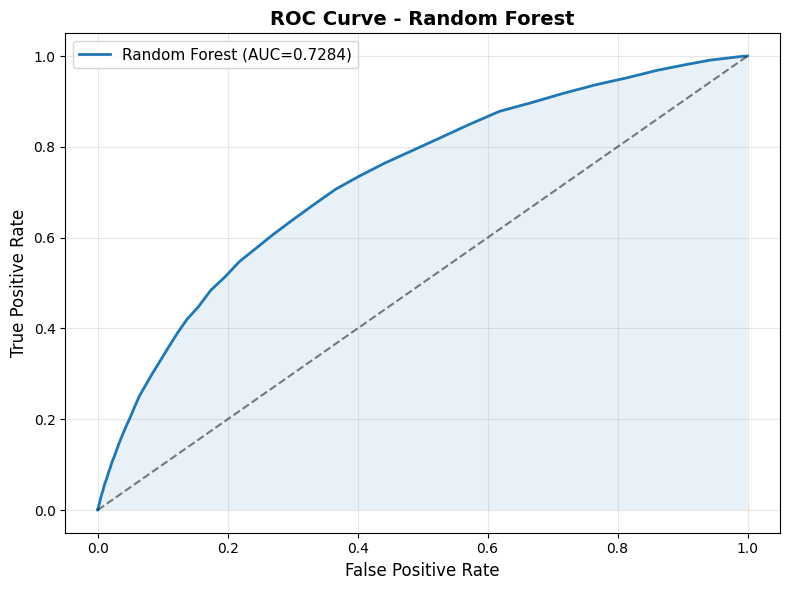

Random Forest Results:
   AUC: 0.7284
   Precision: 0.3409
   Recall: 0.0242
   F1-Score: 0.0451
   Model saved as: model_random_forest.joblib


In [ ]:
# Random Forest
auc_rf = evaluate_model_enhanced(
    RandomForestClassifier(n_estimators=100, random_state=42),
    X_train_rf, X_val_rf, y_train, y_val, "Random Forest"
)


 Training LightGBM...


  File "c:\Users\afsil\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\afsil\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\afsil\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                

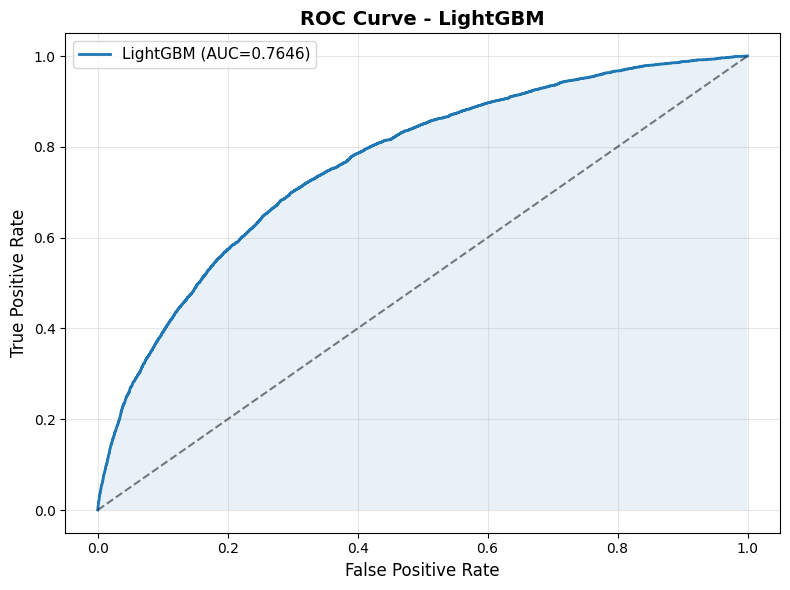

LightGBM Results:
   AUC: 0.7646
   Precision: 0.4978
   Recall: 0.0224
   F1-Score: 0.0428
   Model saved as: model_lightgbm.joblib


In [ ]:
# LightGBM
auc_lgbm = evaluate_model_enhanced(
    lgb.LGBMClassifier(random_state=42, verbose=-1),
    X_train_lgbm, X_val_lgbm, y_train, y_val, "LightGBM"
)


 Training XGBoost...


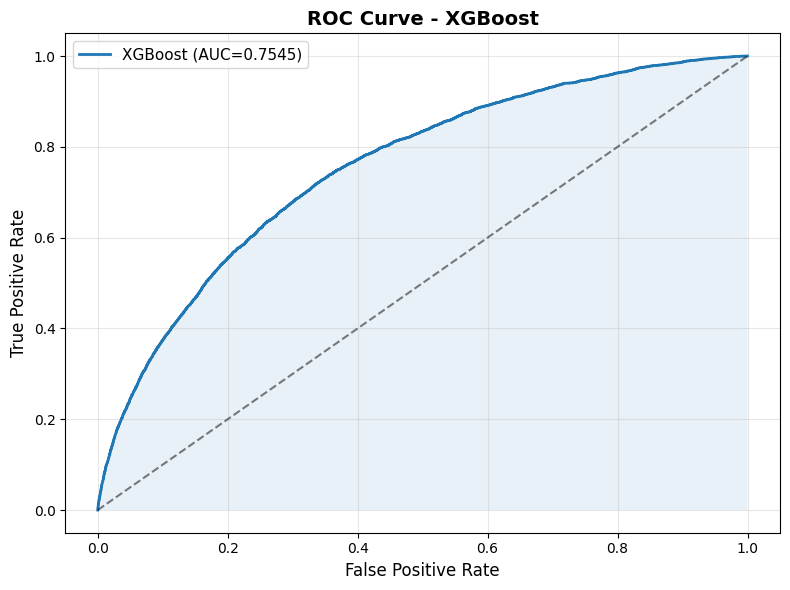

XGBoost Results:
   AUC: 0.7545
   Precision: 0.4541
   Recall: 0.0348
   F1-Score: 0.0647
   Model saved as: model_xgboost.joblib


In [ ]:
# XGBoost
auc_xgb = evaluate_model_enhanced(
    xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, verbosity=0),
    X_train_xgb, X_val_xgb, y_train, y_val, "XGBoost"
)


 Training CatBoost...


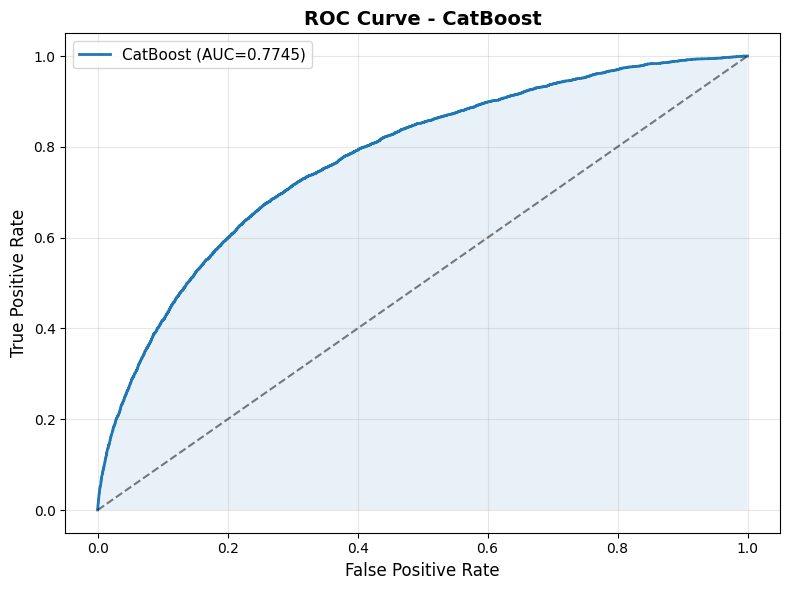

CatBoost Results:
   AUC: 0.7745
   Precision: 0.1980
   Recall: 0.6371
   F1-Score: 0.3021
   Model saved as: model_catboost.joblib


In [ ]:
# CatBoost
class_counts = Counter(y_train_cb)
total = sum(class_counts.values())

class_weights = {
    cls: total / (len(class_counts) * count)
    for cls, count in class_counts.items()
}

auc_cb = evaluate_model_enhanced(
    cb.CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_cols_cb, class_weights=class_weights),
    X_train_cb, X_val_cb, y_train_cb, y_val_cb, "CatBoost"
)


 Training Naive Bayes...


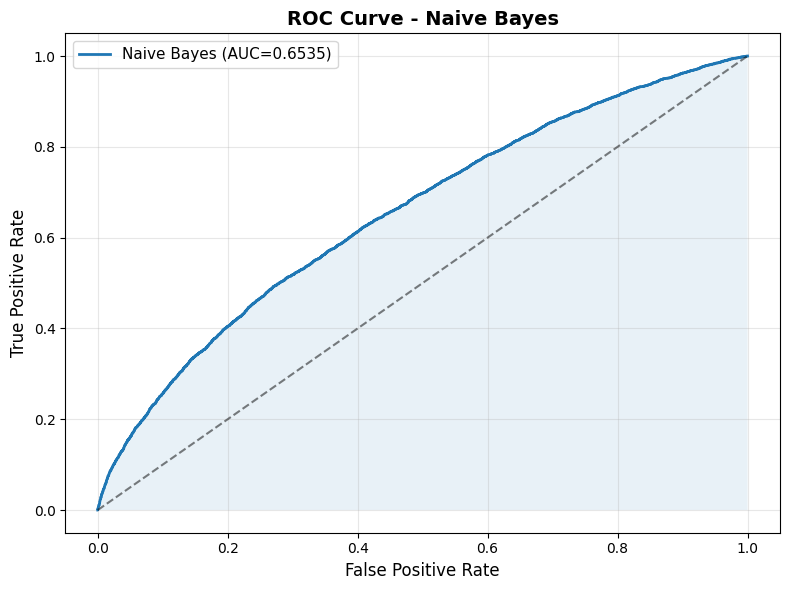

Naive Bayes Results:
   AUC: 0.6535
   Precision: 0.1394
   Recall: 0.4785
   F1-Score: 0.2159
   Model saved as: model_naive_bayes.joblib


In [ ]:
# Naive Bayes
auc_nb = evaluate_model_enhanced(
    GaussianNB(),
    X_train_nb, X_val_nb, y_train, y_val, "Naive Bayes"
)

In [ ]:
# Model comparison visualization
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'AUC': [results[model]['auc'] for model in results.keys()],
    'Precision': [results[model]['precision'] for model in results.keys()],
    'Recall': [results[model]['recall'] for model in results.keys()],
    'F1-Score': [results[model]['f1'] for model in results.keys()]
})

results_df = results_df.sort_values('AUC', ascending=False)
print("MODEL PERFORMANCE SUMMARY:")
display(results_df.round(4))

MODEL PERFORMANCE SUMMARY:


,Model,AUC,Precision,Recall,F1-Score
4,CatBoost,0.7745,0.1980,0.6371,0.3021
2,LightGBM,0.7646,0.4978,0.0224,0.0428
3,XGBoost,0.7545,0.4541,0.0348,0.0647
1,Random Forest,0.7284,0.3409,0.0242,0.0451
5,Naive Bayes,0.6535,0.1394,0.4785,0.2159
0,Logistic Regression,0.5525,0.0986,0.3539,0.1543


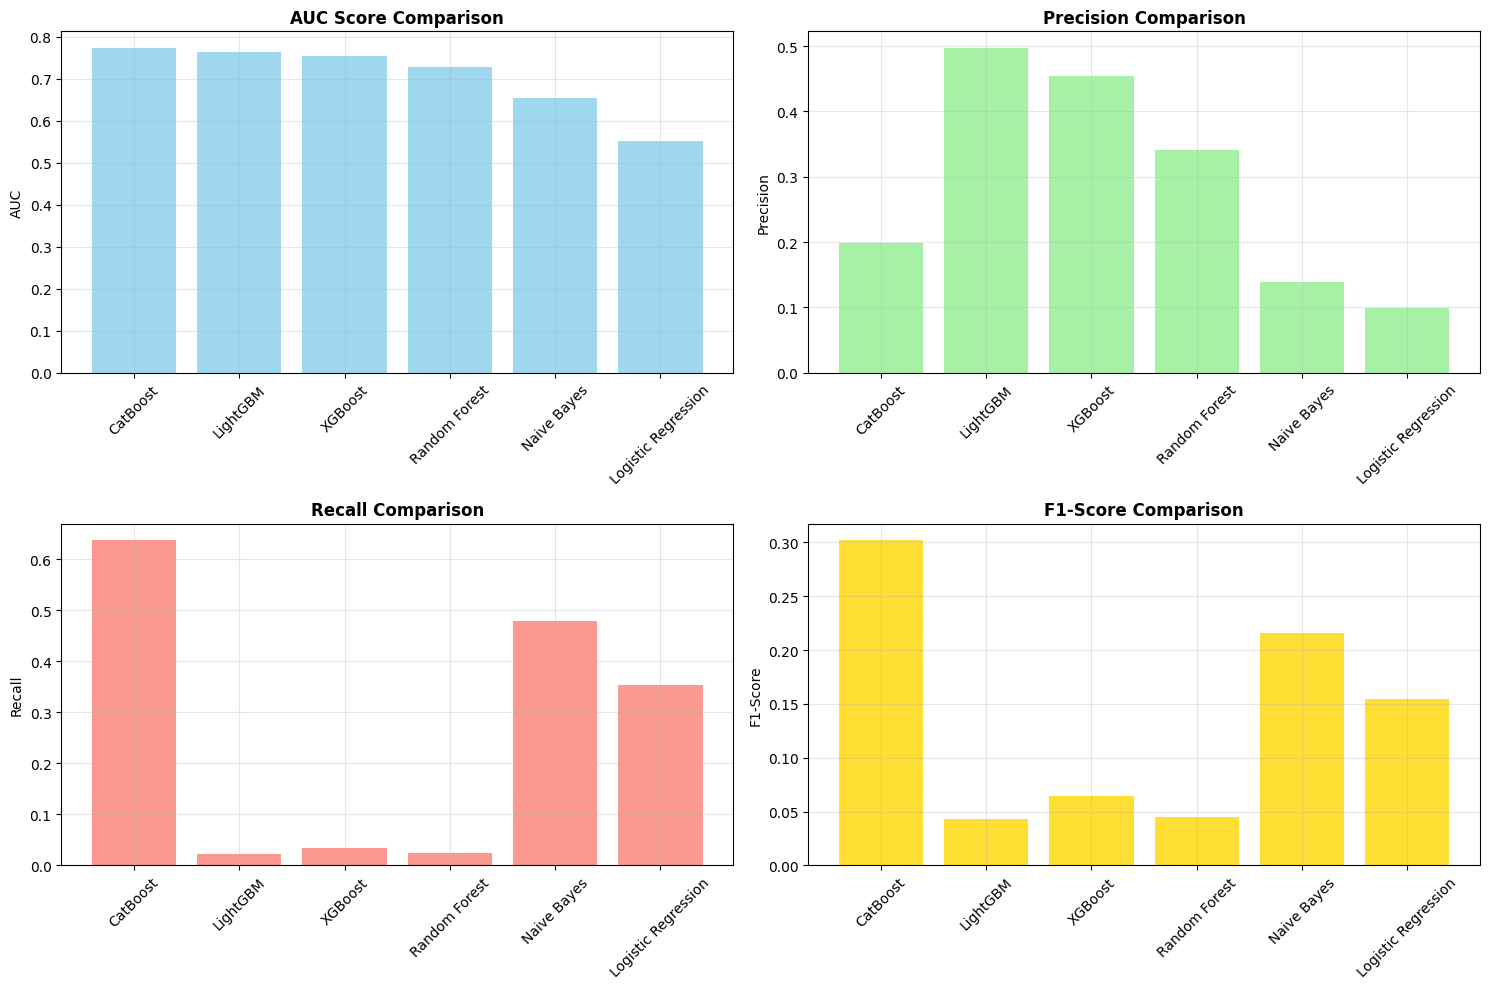


Results saved to 'baseline_model_results.csv'


In [ ]:
# Plot model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# AUC comparison
axes[0,0].bar(results_df['Model'], results_df['AUC'], color='skyblue', alpha=0.8)
axes[0,0].set_title('AUC Score Comparison', fontweight='bold')
axes[0,0].set_ylabel('AUC')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(True, alpha=0.3)

# Precision comparison
axes[0,1].bar(results_df['Model'], results_df['Precision'], color='lightgreen', alpha=0.8)
axes[0,1].set_title('Precision Comparison', fontweight='bold')
axes[0,1].set_ylabel('Precision')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(True, alpha=0.3)

# Recall comparison
axes[1,0].bar(results_df['Model'], results_df['Recall'], color='salmon', alpha=0.8)
axes[1,0].set_title('Recall Comparison', fontweight='bold')
axes[1,0].set_ylabel('Recall')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# F1-Score comparison
axes[1,1].bar(results_df['Model'], results_df['F1-Score'], color='gold', alpha=0.8)
axes[1,1].set_title('F1-Score Comparison', fontweight='bold')
axes[1,1].set_ylabel('F1-Score')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Save results
results_df.to_csv('baseline_model_results.csv', index=False)
print("\nResults saved to 'baseline_model_results.csv'")

# **3. Model Optimization**

### **3.1. Hyperparameter Tuning**

In [ ]:
# LightGBM hyperparameter tuning
lgbm_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [4, 6, 8],
    'num_leaves': [31, 64, 127],
    'min_child_samples': [20, 40],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

lgbm_model = lgb.LGBMClassifier(random_state=42, verbose=-1)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

lgbm_search = RandomizedSearchCV(
    lgbm_model, lgbm_params, n_iter=30,
    scoring='roc_auc', cv=cv, random_state=42, n_jobs=-1
)

lgbm_search.fit(X_train_lgbm, y_train)
best_lgbm = lgbm_search.best_estimator_

print("LightGBM optimization completed!")
print(f"   Best CV score: {lgbm_search.best_score_:.4f}")
print(f"   Best parameters: {lgbm_search.best_params_}")

# Test best LightGBM
y_pred_lgbm_tuned = best_lgbm.predict_proba(X_val_lgbm)[:, 1]
auc_lgbm_tuned = roc_auc_score(y_val, y_pred_lgbm_tuned)
print(f"   Validation AUC: {auc_lgbm_tuned:.4f}")

# Save tuned model
joblib.dump(best_lgbm, 'best_lgbm_model.joblib')

LightGBM optimization completed!
   Best CV score: 0.9800
   Best parameters: {'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 127, 'n_estimators': 300, 'min_child_samples': 40, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
   Validation AUC: 0.7718


['best_lgbm_model.joblib']

In [9]:
# CatBoost hyperparameter tuning
counter = Counter(y_train_cb)
neg, pos = counter[0], counter[1]
scale_pos_weight = neg / pos

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

cb_params = {
    'iterations': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.15],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7],
    'border_count': [64, 128],
    'bagging_temperature': [0, 1],
    'random_strength': [1, 5]
}

cb_model = cb.CatBoostClassifier(
    verbose=0, random_state=42, cat_features=cat_cols_cb, scale_pos_weight=scale_pos_weight
)

cb_search = RandomizedSearchCV(
    cb_model, cb_params, n_iter=20,
    scoring='roc_auc', cv=cv, random_state=42, n_jobs=1
)

cb_search.fit(X_train_cb, y_train_cb)
best_cb = cb_search.best_estimator_

print("CatBoost optimization completed!")
print(f"   Best CV score: {cb_search.best_score_:.4f}")
print(f"   Best parameters: {cb_search.best_params_}")

# Test best CatBoost
y_pred_cb_tuned = best_cb.predict_proba(X_val_cb)[:, 1]
auc_cb_tuned = roc_auc_score(y_val_cb, y_pred_cb_tuned)
print(f"   Validation AUC: {auc_cb_tuned:.4f}")

# Save tuned model
joblib.dump(best_cb, 'best_catboost_model.joblib')

CatBoost optimization completed!
   Best CV score: 0.7748
   Best parameters: {'random_strength': 1, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 4, 'border_count': 64, 'bagging_temperature': 1}
   Validation AUC: 0.7807


['best_catboost_model.joblib']

### **3.2. Threshold Tuning**

In [6]:
# Final model
best_cb = joblib.load('best_catboost_model.joblib')

final_model = best_cb
y_pred_final = final_model.predict_proba(X_val_cb)[:, 1]
auc_final = roc_auc_score(y_val_cb, y_pred_final)
print(f"   Validation AUC: {auc_final:.4f}")

   Validation AUC: 0.7807


In [7]:
# Threshold tuning
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

best_f1 = 0
best_threshold = 0.5

for t in thresholds:
    y_pred_class = (y_pred_final >= t).astype(int)
    f1 = f1_score(y_val_cb, y_pred_class)
    precision = precision_score(y_val_cb, y_pred_class)
    recall = recall_score(y_val_cb, y_pred_class)

    f1_scores.append(f1)
    precision_scores.append(precision)
    recall_scores.append(recall)

    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nBest threshold for max F1: {best_threshold:.2f}, F1: {best_f1:.4f}")


Best threshold for max F1: 0.69, F1: 0.3313



Precision: 0.27887130075705435
Recall: 0.4080563947633434
F1 Score: 0.3313164349959117


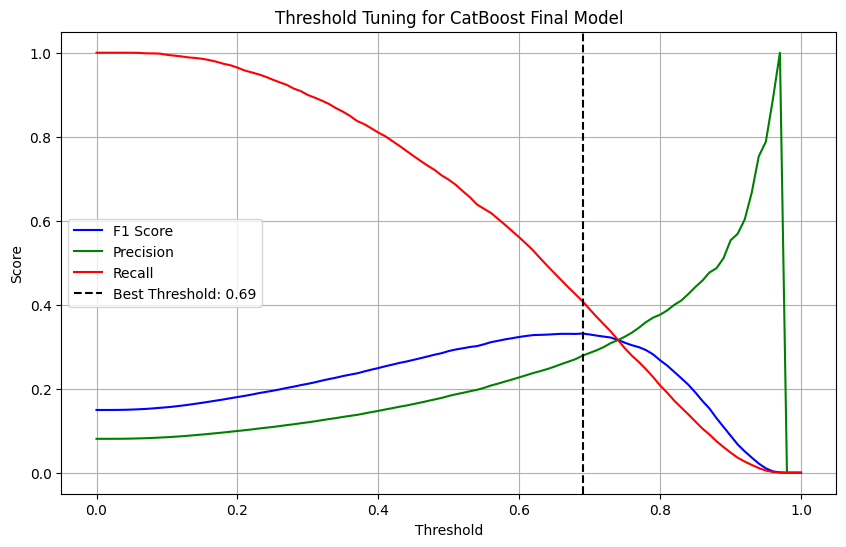

In [8]:
y_pred_opt = (y_pred_final >= best_threshold).astype(int)
print("\nPrecision:", precision_score(y_val_cb, y_pred_opt))
print("Recall:", recall_score(y_val_cb, y_pred_opt))
print("F1 Score:", f1_score(y_val_cb, y_pred_opt))

# Plot Precision, Recall, F1 vs Threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, label='F1 Score', color='blue')
plt.plot(thresholds, precision_scores, label='Precision', color='green')
plt.plot(thresholds, recall_scores, label='Recall', color='red')
plt.axvline(best_threshold, color='black', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Tuning for CatBoost Final Model')
plt.legend()
plt.grid(True)
plt.show()

### **3.2. Final Model Evaluation**

In [9]:
# Model evaluation and visualization
print(f"FINAL MODEL PERFORMANCE:")
print(f"   Model: CatBoost (Optimized)")
print(f"   Validation AUC: {auc_final:.4f}")

# Classification metrics
print(f"\nClassification Report:")
print(classification_report(y_val_cb, y_pred_opt))

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_val_cb, y_pred_opt)
print(cm)

FINAL MODEL PERFORMANCE:
   Model: CatBoost (Optimized)
   Validation AUC: 0.7802

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.89      0.92     56538
           1       0.26      0.46      0.33      4965

    accuracy                           0.85     61503
   macro avg       0.61      0.67      0.63     61503
weighted avg       0.89      0.85      0.87     61503


Confusion Matrix:
[[50083  6455]
 [ 2679  2286]]


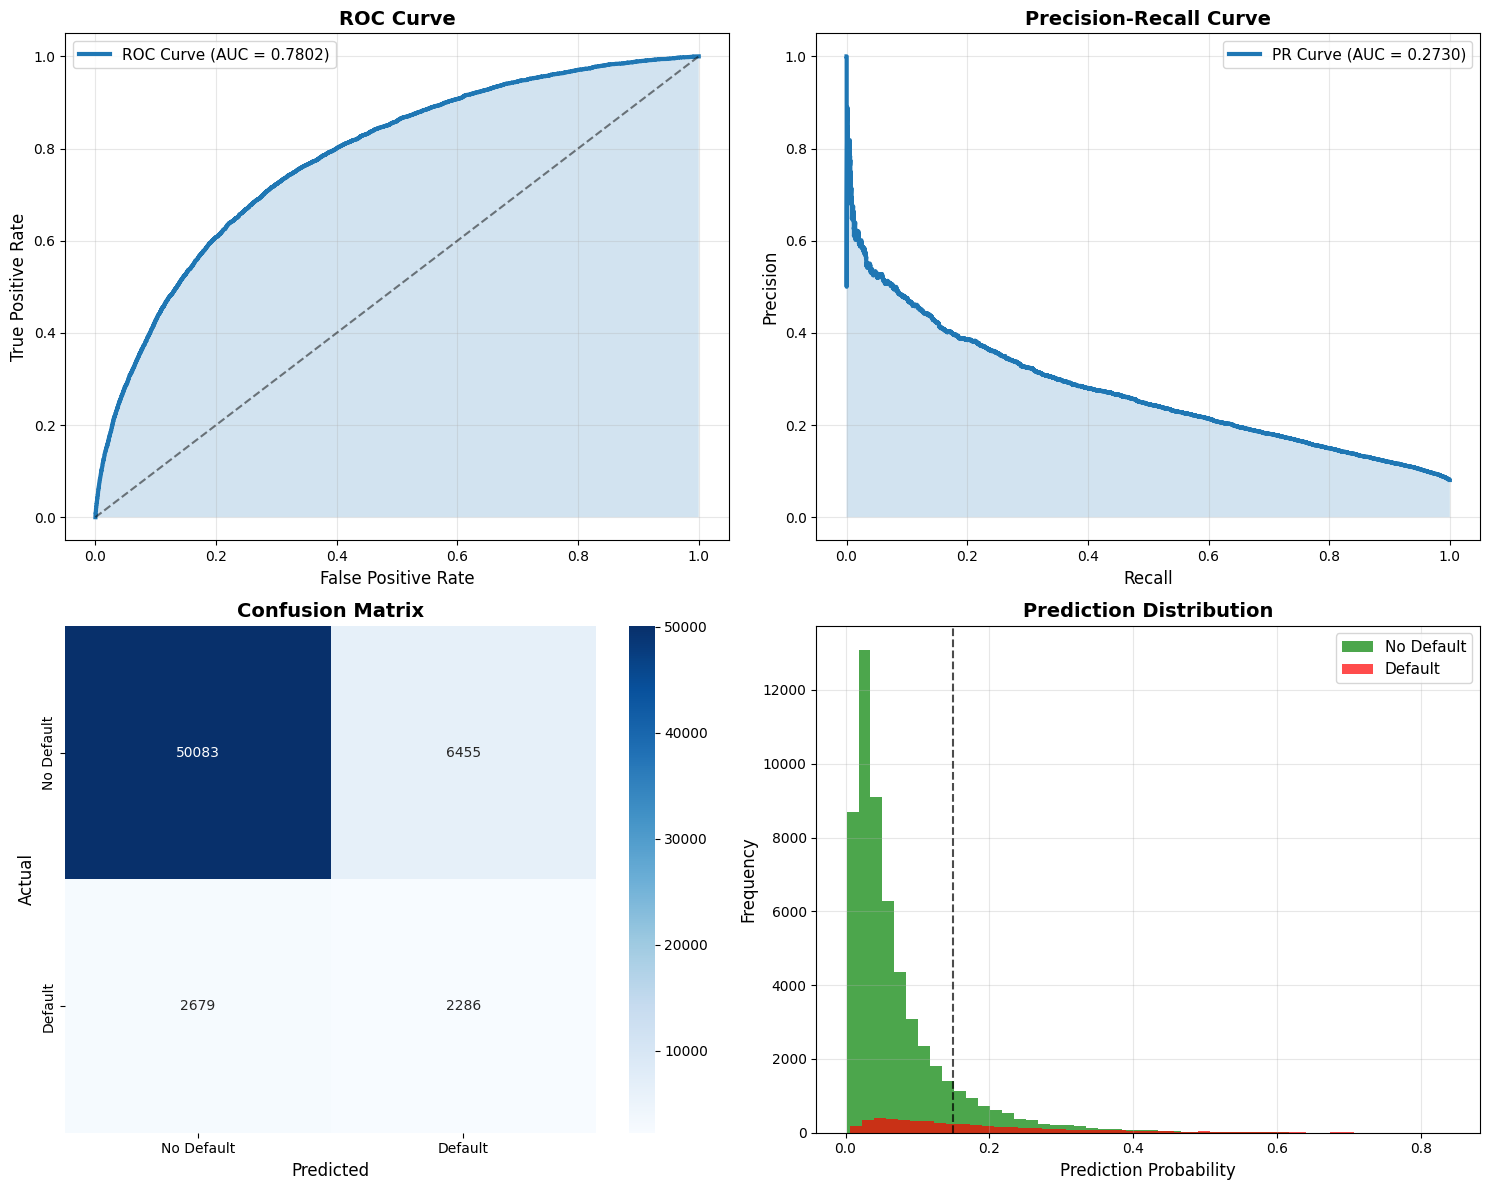

In [10]:
# Model evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(y_val_cb, y_pred_final)
axes[0,0].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {auc_final:.4f})')
axes[0,0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0,0].fill_between(fpr, tpr, alpha=0.2)
axes[0,0].set_xlabel('False Positive Rate', fontsize=12)
axes[0,0].set_ylabel('True Positive Rate', fontsize=12)
axes[0,0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0,0].legend(fontsize=11)
axes[0,0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val_cb, y_pred_final)
pr_auc = auc(recall, precision)
axes[0,1].plot(recall, precision, linewidth=3, label=f'PR Curve (AUC = {pr_auc:.4f})')
axes[0,1].fill_between(recall, precision, alpha=0.2)
axes[0,1].set_xlabel('Recall', fontsize=12)
axes[0,1].set_ylabel('Precision', fontsize=12)
axes[0,1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0,1].legend(fontsize=11)
axes[0,1].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'],
            ax=axes[1,0])
axes[1,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Predicted', fontsize=12)
axes[1,0].set_ylabel('Actual', fontsize=12)

# Prediction Distribution
axes[1,1].hist(y_pred_final[y_val_cb == 0], bins=50, alpha=0.7, label='No Default', color='green')
axes[1,1].hist(y_pred_final[y_val_cb == 1], bins=50, alpha=0.7, label='Default', color='red')
axes[1,1].axvline(x=best_threshold, color='black', linestyle='--', alpha=0.7)
axes[1,1].set_xlabel('Prediction Probability', fontsize=12)
axes[1,1].set_ylabel('Frequency', fontsize=12)
axes[1,1].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[1,1].legend(fontsize=11)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Perform 5-fold cross-validation
cv_scores = cross_val_score(
    best_cb,
    X_train_cb,
    y_train_cb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

print("Cross-Validation AUC Scores:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f}")

print(f"   Mean CV AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize CV results
plt.figure(figsize=(10, 6))
plt.bar(range(1, 6), cv_scores, color='lightblue', alpha=0.7)
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--',
           label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(),
                cv_scores.mean() + cv_scores.std(), alpha=0.2, color='red')
plt.xlabel('Cross-Validation Fold')
plt.ylabel('AUC Score')
plt.title('5-Fold Cross-Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### **3.3. Model Performance by Training Size**

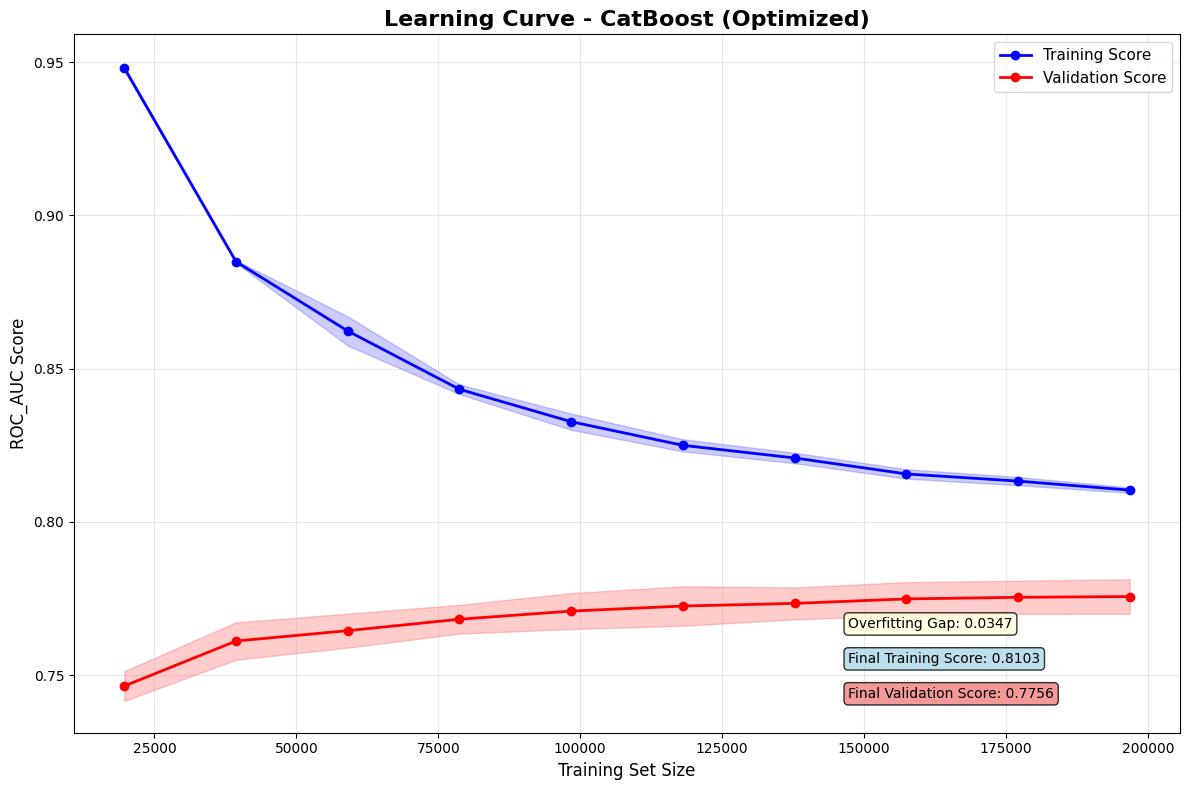

In [31]:
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes_abs, train_scores, val_scores = learning_curve(
    best_cb, X_train_cb, y_train_cb,
    train_sizes=train_sizes,
    cv=5,
    scoring='roc_auc',
    n_jobs=1
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(12, 8))

plt.plot(train_sizes_abs, train_mean, 'o-', color='blue', label='Training Score', linewidth=2, markersize=6)
plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')

plt.plot(train_sizes_abs, val_mean, 'o-', color='red', label='Validation Score', linewidth=2, markersize=6)
plt.fill_between(train_sizes_abs, val_mean - val_std, val_mean + val_std, alpha=0.2, color='red')

plt.xlabel('Training Set Size', fontsize=12)
plt.ylabel('ROC_AUC Score', fontsize=12)
plt.title('Learning Curve - CatBoost (Optimized)', fontsize=16, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Tambahan info
final_train_score = train_mean[-1]
final_val_score = val_mean[-1]
gap = final_train_score - final_val_score

plt.text(0.7, 0.1, f'Final Training Score: {final_train_score:.4f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
plt.text(0.7, 0.05, f'Final Validation Score: {final_val_score:.4f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
plt.text(0.7, 0.15, f'Overfitting Gap: {gap:.4f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

### **3.4. Business-Oriented Evaluation**


Business-Oriented Metrics:
   Approval Rate: 88.19%
   Default Rate (approved): 5.42%


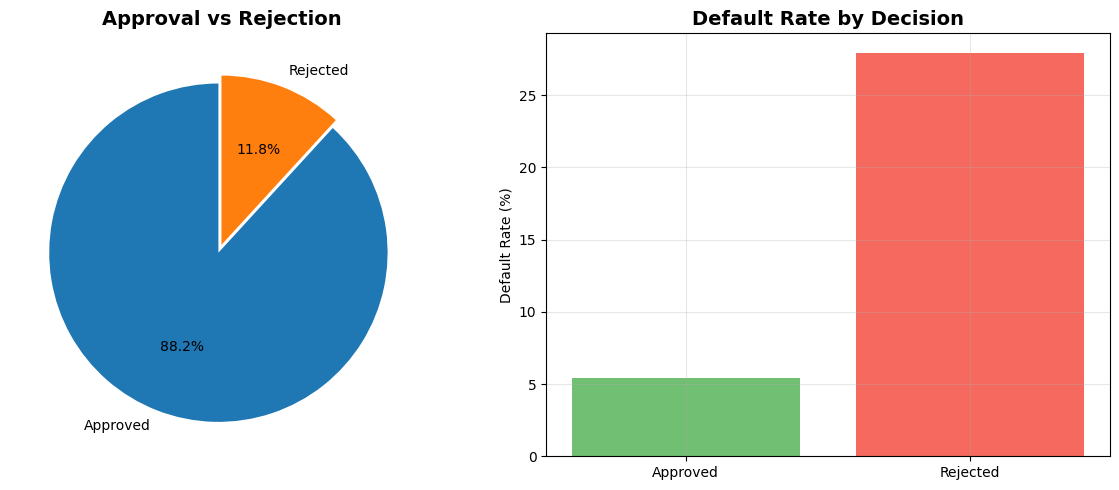

In [9]:
# Define approved applicants 
approved = y_pred_final <= best_threshold  
rejected = ~approved

# Approval rate
approval_rate = approved.mean() * 100

# Default rate among approved
default_rate_model = y_val_cb[approved].mean() * 100

print("\nBusiness-Oriented Metrics:")
print(f"   Approval Rate: {approval_rate:.2f}%")
print(f"   Default Rate (approved): {default_rate_model:.2f}%")

# Visualization 
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].pie(
    [approved.sum(), rejected.sum()],
    labels=['Approved', 'Rejected'],
    autopct='%1.1f%%',
    startangle=90,
    explode=[0.05, 0]
)
axes[0].set_title('Approval vs Rejection', fontsize=14, fontweight='bold')

# Default rate among approved vs rejected
default_rate_approved = y_val_cb[approved].mean() * 100
default_rate_rejected = y_val_cb[rejected].mean() * 100

axes[1].bar(
    ['Approved', 'Rejected'],
    [default_rate_approved, default_rate_rejected],
    color=['#4CAF50', '#F44336'],
    alpha=0.8
)
axes[1].set_ylabel('Default Rate (%)')
axes[1].set_title('Default Rate by Decision', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# **4. Model Interpretation**

### **4.1. Feature Importance**

Top 15 Most Important Features:
                feature  importance
           EXT_SOURCE_3   12.247472
           EXT_SOURCE_2   10.175730
           EXT_SOURCE_1   10.155899
   CREDIT_ANNUITY_RATIO    6.183820
             DAYS_BIRTH    4.579226
        AMT_GOODS_PRICE    3.523279
 POS_INSTAL_FUTURE_MEAN    3.492145
INST_PAYMENT_RATIO_MEAN    2.929716
            AMT_ANNUITY    2.885390
      BUREAU_CREDIT_SUM    2.805745
          DAYS_EMPLOYED    2.564746
        CC_BALANCE_MEAN    2.368533
    PREV_APPROVED_COUNT    2.278980
            CODE_GENDER    2.186249
      DEBT_CREDIT_RATIO    2.096537


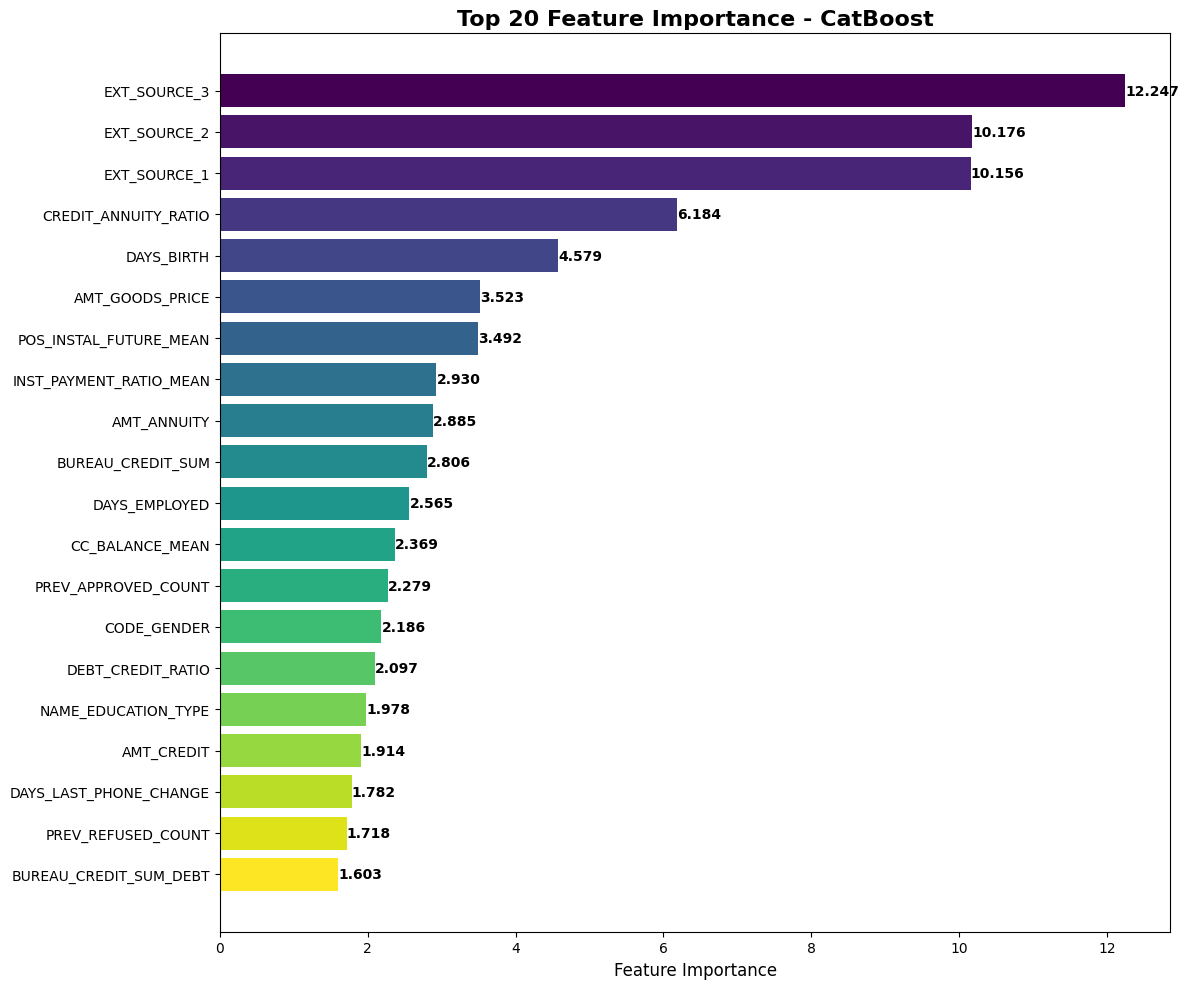

Feature importance saved to 'feature_importance.csv'


In [ ]:
# Feature importance analysis
if hasattr(final_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X_train_cb.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 15 Most Important Features:")
    print(feature_importance.head(15).to_string(index=False))

    # Enhanced feature importance plot
    plt.figure(figsize=(12, 10))
    top_features = feature_importance.head(20)

    bars = plt.barh(range(len(top_features)), top_features['importance'])

    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance', fontsize=12)
    plt.title('Top 20 Feature Importance - CatBoost', fontsize=16, fontweight='bold')
    plt.gca().invert_yaxis()

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Save feature importance
    feature_importance.to_csv('feature_importance.csv', index=False)
    print("Feature importance saved to 'feature_importance.csv'")

### **4.2. SHAP Analysis**

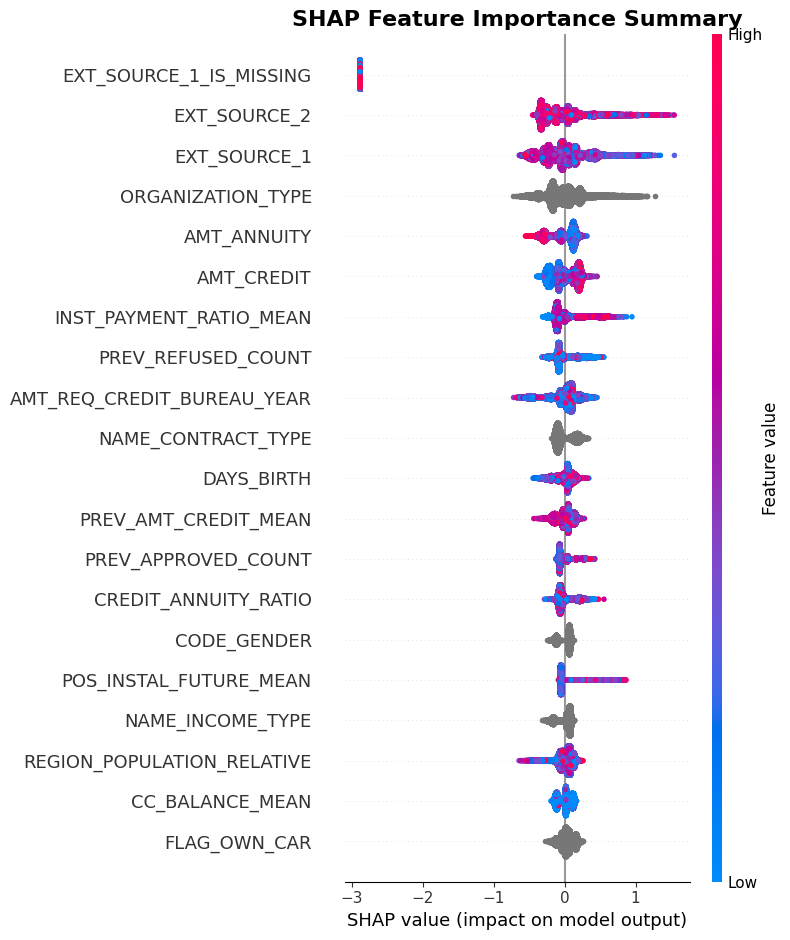

SHAP analysis completed!


In [ ]:
# SHAP analysis
val_pool = Pool(X_val_cb, y_val_cb, cat_features=cat_cols_cb)
shap_values = final_model.get_feature_importance(type='ShapValues', data=val_pool)

shap_values_only = shap_values[:, 1:]
feature_names = X_val_cb.columns

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_only, X_val_cb, feature_names=feature_names, show=False)
plt.title('SHAP Feature Importance Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("SHAP analysis completed!")

### **4.3. Feature Distribution Analysis**

Top Features Distribution Analysis:
   EXT_SOURCE_3:
      Default: -0.4595, Non-Default: -0.0051
      Difference: 0.4544


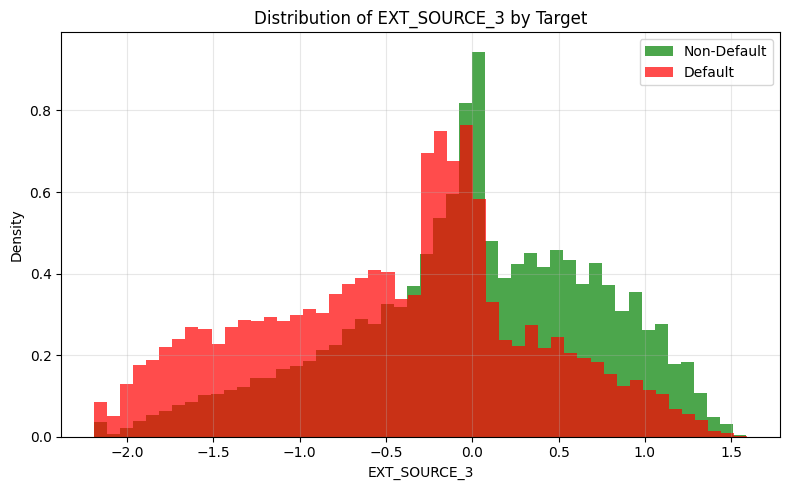

   EXT_SOURCE_2:
      Default: -0.5688, Non-Default: -0.1559
      Difference: 0.4129


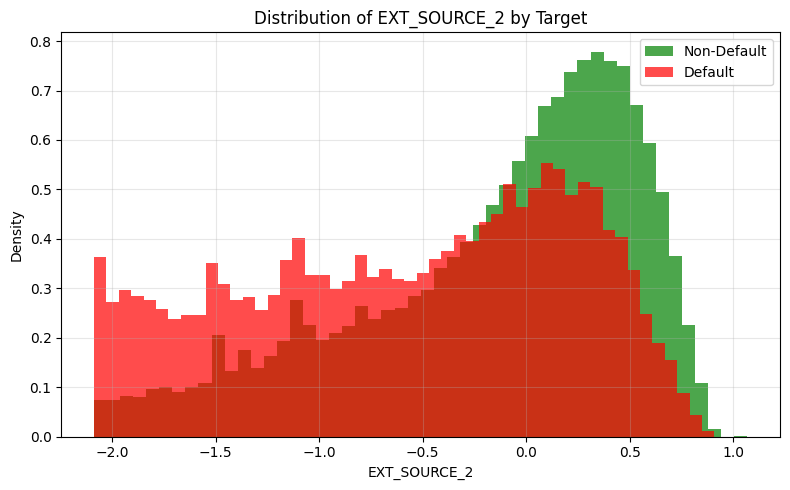

   EXT_SOURCE_1:
      Default: -0.5595, Non-Default: -0.0047
      Difference: 0.5549


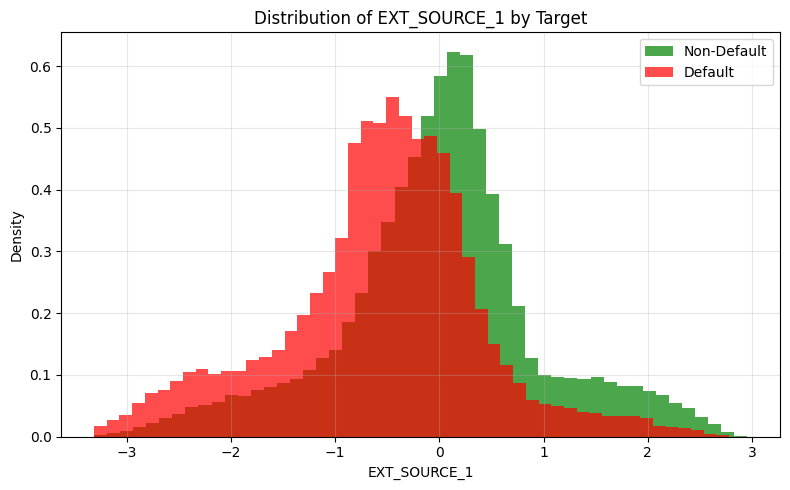

   CREDIT_ANNUITY_RATIO:
      Default: 0.0653, Non-Default: 0.1485
      Difference: 0.0832


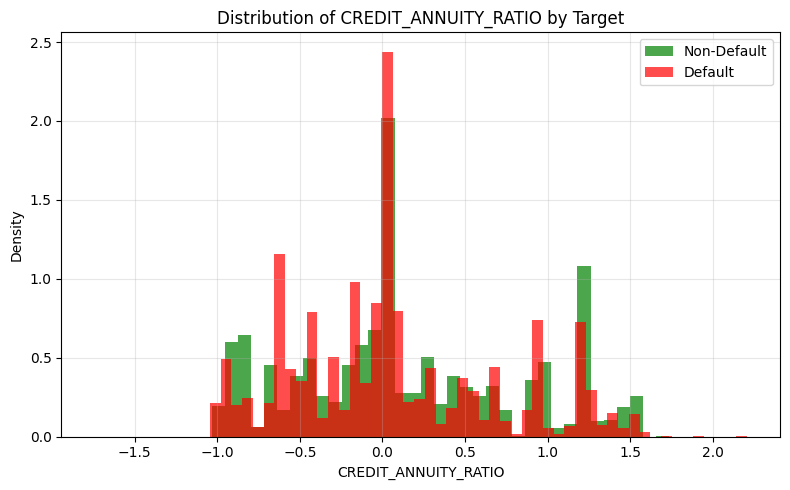

   DAYS_BIRTH:
      Default: 0.1216, Non-Default: -0.0534
      Difference: 0.1750


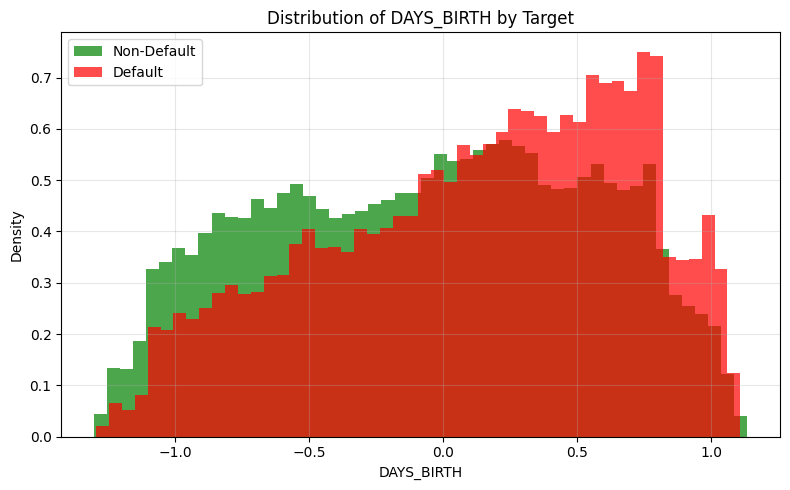

   AMT_GOODS_PRICE:
      Default: 0.0770, Non-Default: 0.1859
      Difference: 0.1090


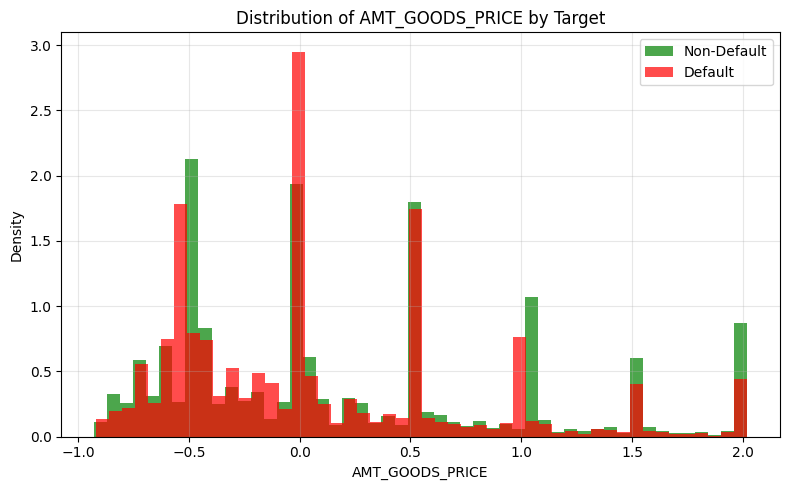

   POS_INSTAL_FUTURE_MEAN:
      Default: 0.3424, Non-Default: 0.2550
      Difference: 0.0874


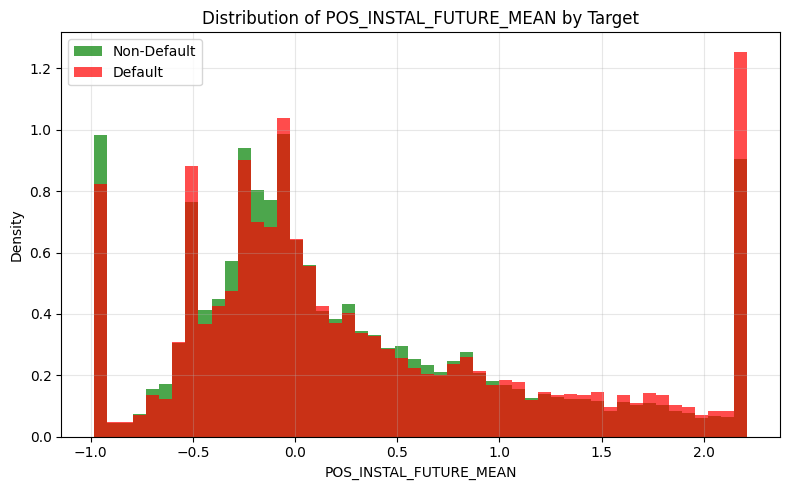

   INST_PAYMENT_RATIO_MEAN:
      Default: -0.6489, Non-Default: -0.4557
      Difference: 0.1933


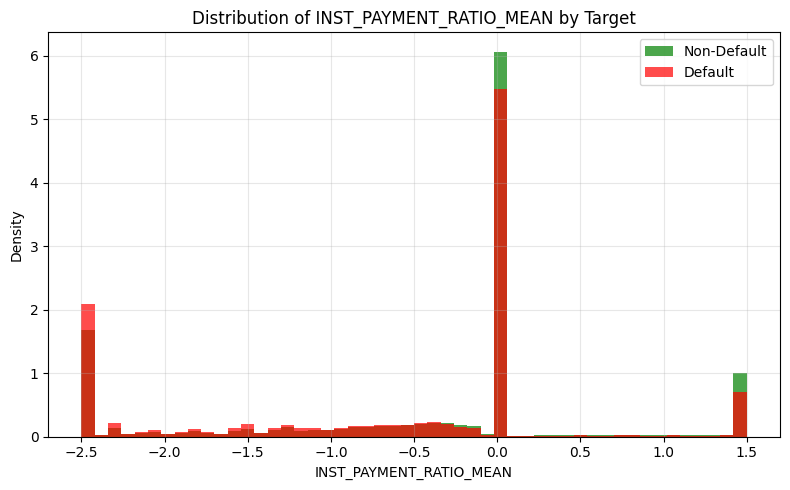

   AMT_ANNUITY:
      Default: 0.0811, Non-Default: 0.1066
      Difference: 0.0256


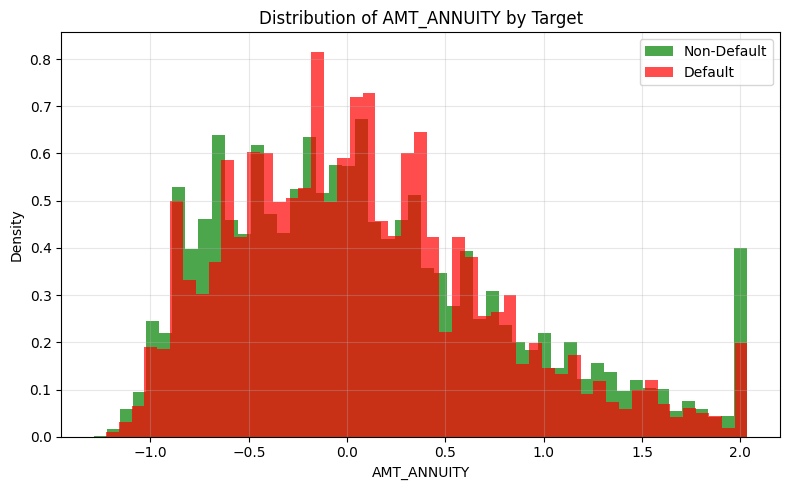

   BUREAU_CREDIT_SUM:
      Default: -0.3580, Non-Default: -0.2356
      Difference: 0.1224


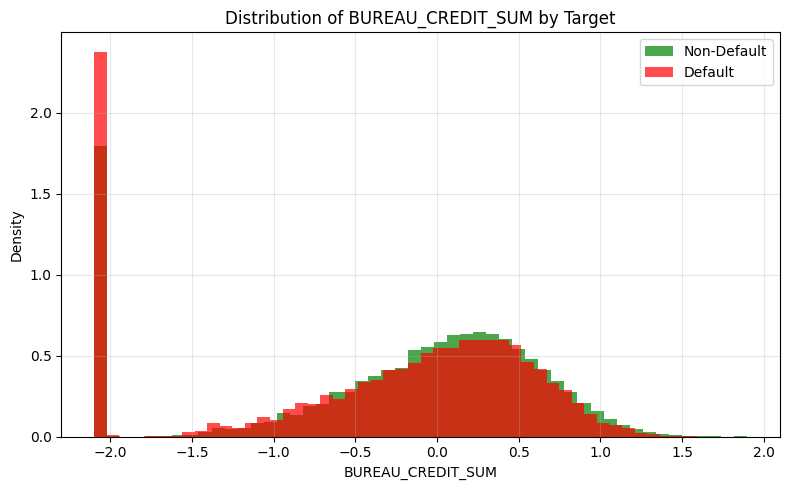

In [ ]:
# Analyze top features distribution by target
top_features = feature_importance.head(10)['feature'].tolist()

print("Top Features Distribution Analysis:")
for feature in top_features:
    if feature in X_train_cb.columns:
        # Calculate statistics
        default_mean = X_train_cb[y_train_cb == 1][feature].mean()
        non_default_mean = X_train_cb[y_train_cb == 0][feature].mean()
        difference = abs(default_mean - non_default_mean)

        print(f"   {feature}:")
        print(f"      Default: {default_mean:.4f}, Non-Default: {non_default_mean:.4f}")
        print(f"      Difference: {difference:.4f}")

        # Simple visualization
        plt.figure(figsize=(8, 5))
        plt.hist(X_train_cb[y_train_cb == 0][feature], bins=50, alpha=0.7,
                label='Non-Default', color='#808080', density=True)
        plt.hist(X_train_cb[y_train_cb == 1][feature], bins=50, alpha=0.7,
                label='Default', color='red', density=True)
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.title(f'Distribution of {feature} by Target')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# **5. Model Persistence & Deployment Preparation**

In [ ]:
# Save the final model with metadata
model_info = {
    'model': best_cb,
    'features': cb_features,
    'categorical_features': cat_cols_cb,
    'performance': {
        'validation_auc': auc_cb_tuned,
        'cv_mean_auc': cv_scores.mean(),
        'cv_std_auc': cv_scores.std()
    },
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'feature_importance': feature_importance.to_dict()
}

# Save complete model package
joblib.dump(model_info, 'final_model_package.joblib')
print("Complete model package saved as 'final_model_package.joblib'")

# Create a simple test function for deployment
def predict_default_probability(new_data, model_package):
    """
    Simple prediction function for deployment
    """
    # Load model info
    model = model_package['model']
    features = model_package['features']
    cat_features = model_package['categorical_features']

    # Ensure correct features
    new_data = new_data[features]

    # Predict
    probability = model.predict_proba(new_data)[:, 1]

    return probability

# Test the prediction function
print("\nTesting prediction function with sample data:")
sample_data = X_val_cb.iloc[:5].copy()
predictions = predict_default_probability(sample_data, model_info)
print(f"   Sample predictions: {predictions}")

Complete model package saved as 'final_model_package.joblib'

Testing prediction function with sample data:
   Sample predictions: [0.03737615 0.0814789  0.30175957 0.04784604 0.10611833]


In [ ]:
# Summary report
summary_data = {
    'Model': ['CatBoost (Optimized)'],
    'Validation_AUC': [auc_cb_tuned],
    'CV_Mean_AUC': [cv_scores.mean()],
    'CV_Std_AUC': [cv_scores.std()],
    'Precision': [results['CatBoost']['precision']],
    'Recall': [results['CatBoost']['recall']],
    'F1_Score': [results['CatBoost']['f1']]
}

summary_df = pd.DataFrame(summary_data)

print("FINAL MODEL PERFORMANCE SUMMARY:")
print(summary_df.to_string(index=False))

summary_df.to_csv("final_model_summary.csv", index=False)
print("Summary saved to final_model_summary.csv")

TypeError: list indices must be integers or slices, not str